In [180]:
import torchdyn
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchdyn.numerics import Euler, RungeKutta4, Tsitouras45, DormandPrince45
from torchdyn.numerics import odeint

import torchdiffeq
import time 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [189]:
class VanDerPol(nn.Module):
    def __init__(self, alpha=10):
        super().__init__()
        self.alpha = alpha
        self.nfe = 0

    def forward(self, t, z):
        self.nfe += 1
        x1, x2 = z[...,:1], z[...,1:2]
        return torch.cat([x2, self.alpha * (1 - x1**2) * x2 - x1], -1)

In [202]:
f = VanDerPol()
x = torch.randn(1024, 2)
t_span = torch.linspace(0, 5, 200)

#### Fixed--step bench

In [225]:
t0 = time.time()
t_eval, sol1 = odeint(f, x, t_span, solver='rk4')
t_end1 = time.time() - t0
print(t_end1)

t0 = time.time()
sol2 = torchdiffeq.odeint(f, x, t_span, method='rk4')
t_end2 = time.time() - t0
print(t_end2)

true_sol = torchdiffeq.odeint(f, x, t_span, method='dopri5', atol=1e-9, rtol=1e-9)

0.0464940071105957
0.05103945732116699


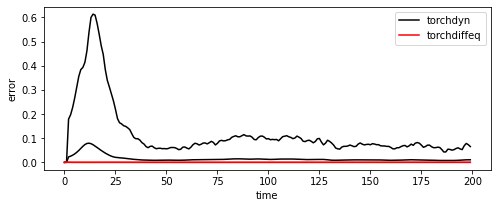

In [226]:
fig = plt.figure(figsize=(8,3))
ax = plt.subplot(111)
line, _ = ax.plot((sol1-true_sol).abs().mean(1), c='black')
line.set_label('torchdyn')
line, _ = ax.plot((sol2-true_sol).abs().mean(1), c='red')
line.set_label('torchdiffeq')
ax.set_ylabel('error')
ax.set_xlabel('time')
plt.legend()

#### Adaptive-step bench

In [227]:
t0 = time.time()
t_eval, sol1 = odeint(f, x, t_span, solver='dopri5', atol=1e-4, rtol=1e-4)
t_end1 = time.time() - t0
print(t_end1)

t0 = time.time()
sol2 = torchdiffeq.odeint(f, x, t_span, method='dopri5', atol=1e-4, rtol=1e-4)
t_end2 = time.time() - t0
print(t_end2)

true_sol = torchdiffeq.odeint(f, x, t_span, method='dopri5', atol=1e-9, rtol=1e-9)

0.131972074508667
0.17998409271240234


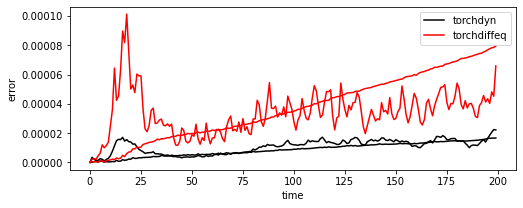

In [228]:
fig = plt.figure(figsize=(8,3))
ax = plt.subplot(111)
line, _ = ax.plot((sol1-true_sol).abs().mean(1), c='black')
line.set_label('torchdyn')
line, _ = ax.plot((sol2-true_sol).abs().mean(1), c='red')
line.set_label('torchdiffeq')
ax.set_ylabel('error')
ax.set_xlabel('time')
plt.legend()